# Film Junky AI: Clasificador de Críticas

## Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [10]:
import math
import re
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [12]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [13]:
# Cargamos los datos

df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [14]:
# Mostramos la información básica del DataFrame

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Solo hay valores nulos en las columnas 'average_rating' y 'votes'

In [15]:
# Mostramos las primeras filas del DataFrame

df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [16]:
# Eliminamos los valores nulos y duplicados
df_reviews.dropna(inplace=True)
df_reviews.drop_duplicates(inplace=True)

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

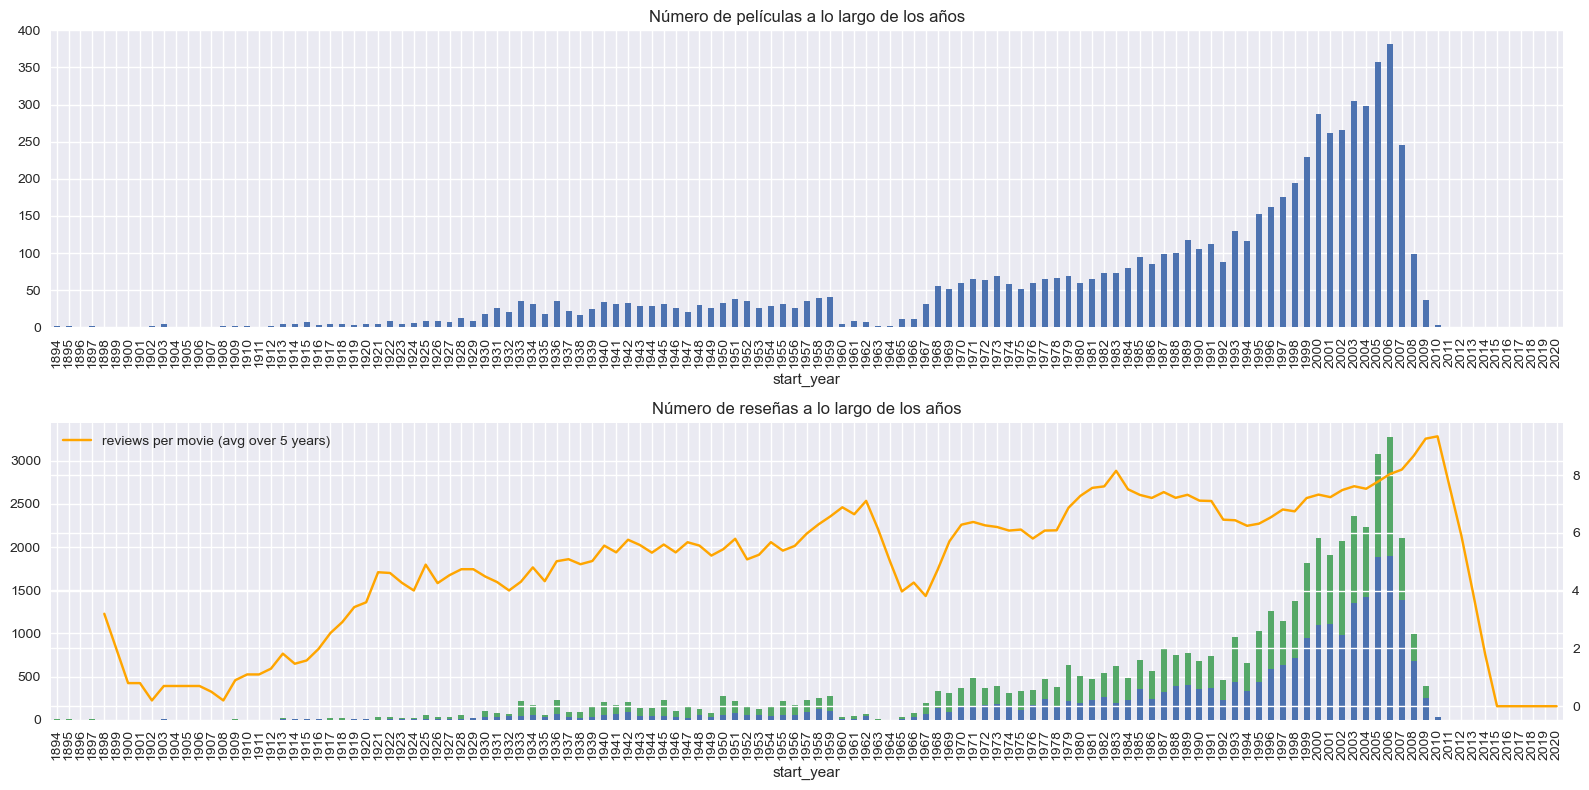

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

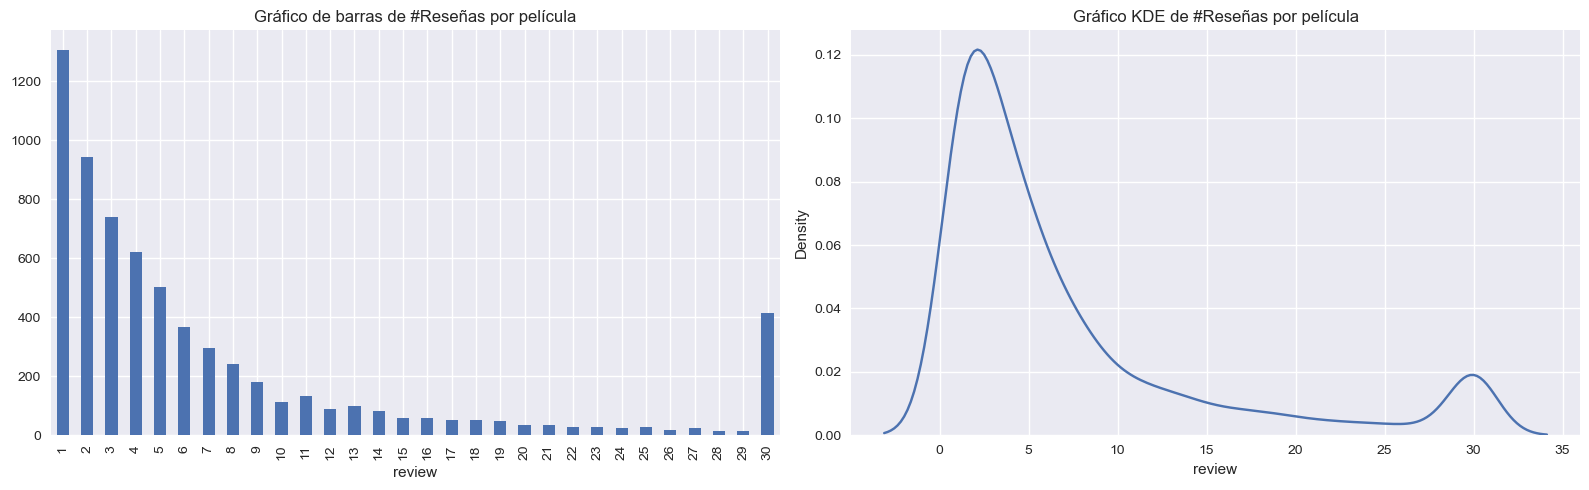

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

1. **Número de peliculas a lo largo de los años:** Mostramos cuantas peliculas se hicieron cada año.
2. **Número de reseñas a lo largo de los años:** Mostramos cuántas críticas fueron buenas y malas cada año, y una línea que indica el promedio de críticas por película.
3. **Gráfico de barras de #Reseñas por película:** Mostramos exactamente cuántas críticas tiene cada pelicula.
4. **Gráfico KDE de #Reseñas por película:** Mostramos cómo se distribuyen las críticas entre las películas.

In [19]:
# Analizamos el desbalanceo de clases

df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

El análisis del balance de clases muestra que el conjunto de datos está casi perfectamente equilibrado.

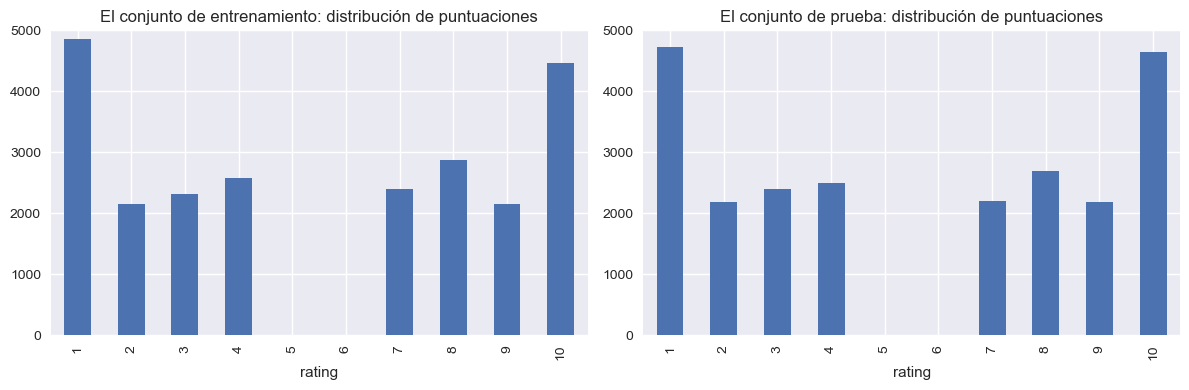

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

El código crea dos gráficos de barras para comprar como se distribuyen las puntuaciones de las reseñas de la columna 'rating' entre los conjuntos de entrenamiento y prueba.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\lalox\AppData\Local\Temp\ipykernel_10268\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\lalox\AppData\Local\Temp\ipykernel_10268\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\lalox\AppData\Local\Temp\ipykernel_10268\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\lalox\AppData\Local\Temp\ipykernel_10268\1324160450.py:31: UserWarning: 

Support for a

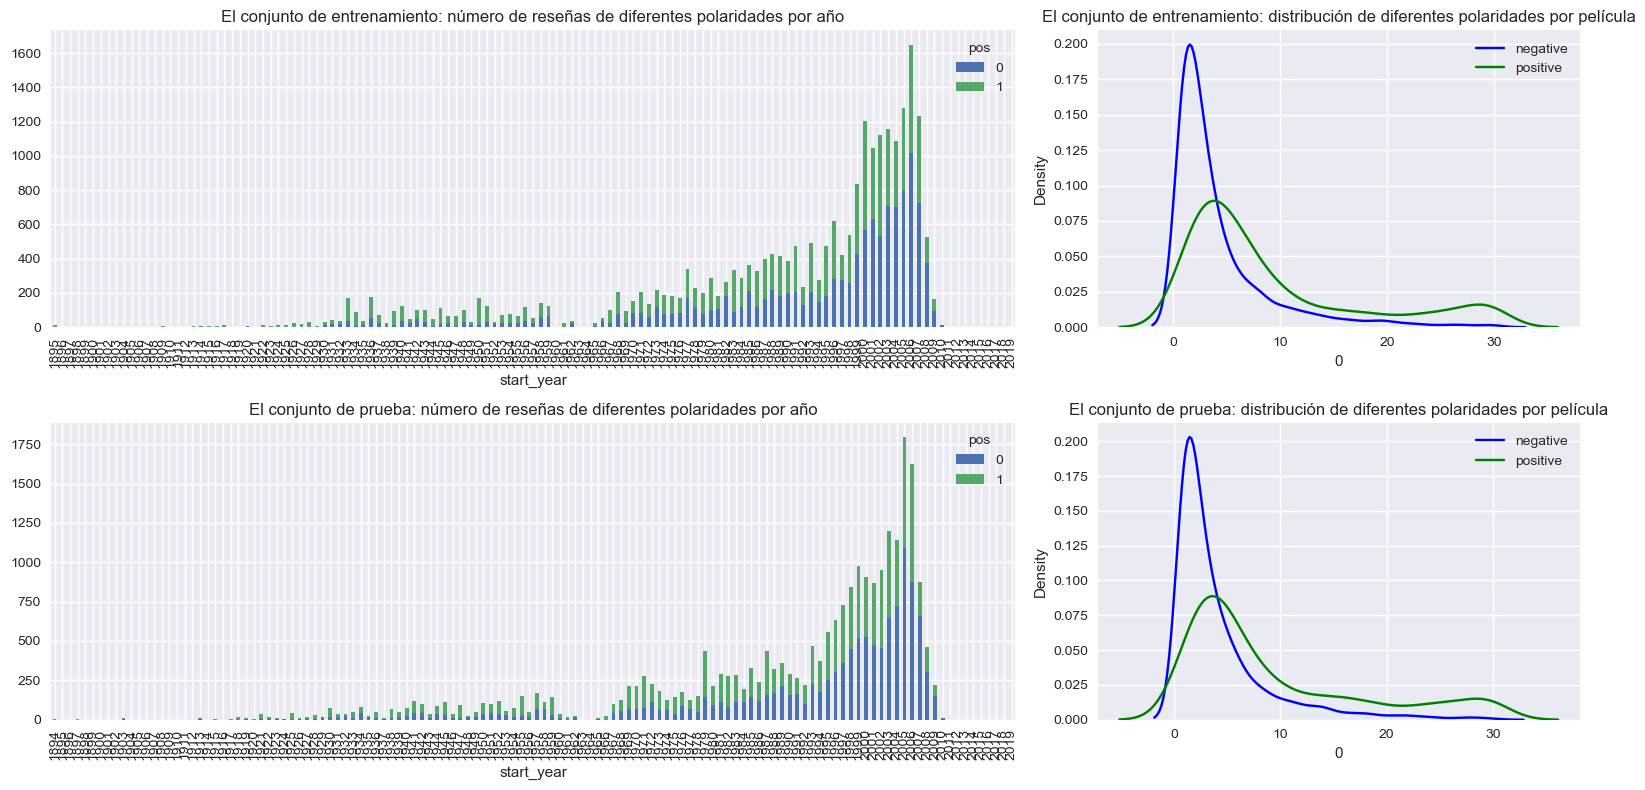

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Este código crea 4 gráficos que analizan la distribución de reseñas positivas/negativas en los datos de entrenamiento y prueba desde dos perspectivas: por año y por película.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [22]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [23]:
# Descargar recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('wordnet')

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Aplicar la normalización a la columna 'review'
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lalox\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lalox\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabajar con modelos

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [25]:
# Convertir las reseñas en matrices de características utilizando TF-IDF

tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_tfidf = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

In [26]:
# Entrenar un modelo de regresión logística

logistic_model = LogisticRegression(max_iter=1000, random_state=12345, class_weight='balanced')

logistic_model.fit(train_tfidf, train_target)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12345)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


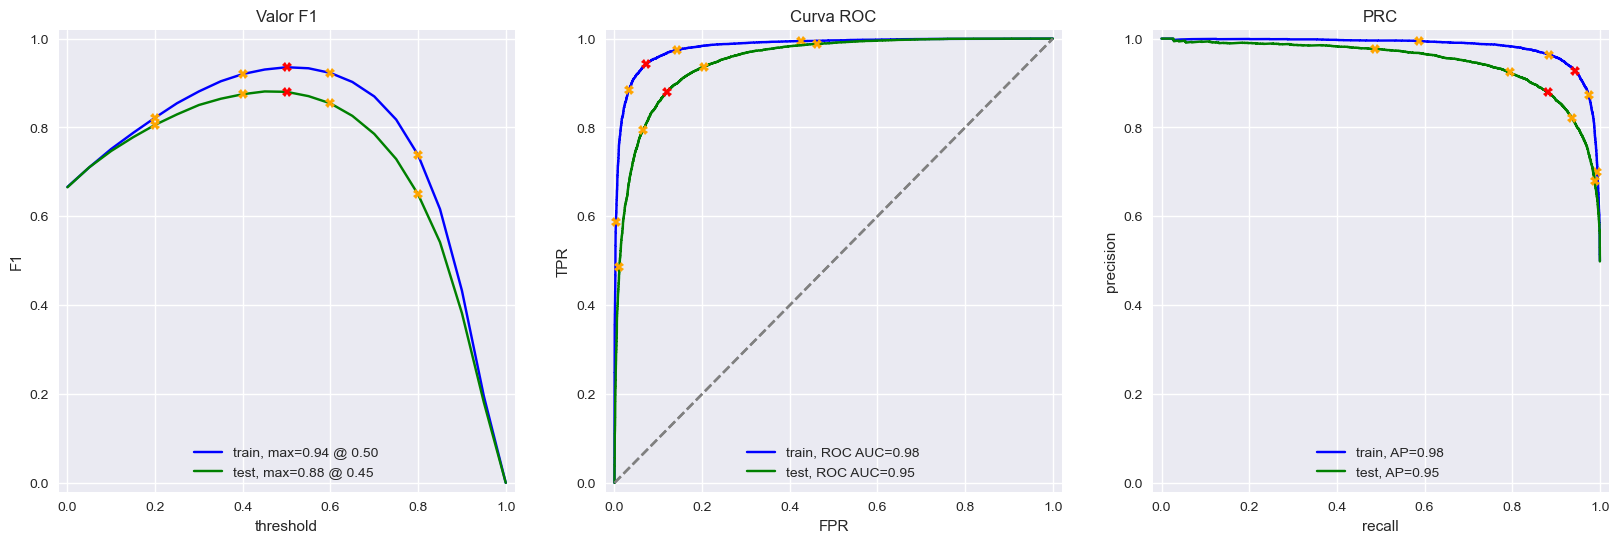

In [27]:
evaluate_model(logistic_model, train_tfidf, train_target, test_tfidf, test_target)

### Modelo 2 - spaCy, TF-IDF y LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def clear_text(text):
    doc = nlp(text)
    cleaned_tokens = []
    for token in doc:
        # Condiciones combinadas para mejor rendimiento
        if (not token.is_stop and 
            not token.is_punct and 
            not token.like_num and
            token.is_alpha and
            len(token.lemma_) > 2):  # Ignorar palabras muy cortas
            cleaned_tokens.append(token.lemma_.lower())
    return " ".join(cleaned_tokens)

In [30]:
# Seleccionamos solo una muestra para entrenar el modelo, ya que con Spacy es más lento

sample_train = df_reviews_train.groupby('pos', group_keys=False).apply(lambda x: x.sample(5000))
sample_test = df_reviews_test.groupby('pos', group_keys=False).apply(lambda x: x.sample(5000))

sample_train['clear_text'] = [clear_text(text) for text in tqdm(sample_train['review'])]
sample_test['clear_text'] = [clear_text(text) for text in tqdm(sample_test['review'])]

C:\Users\lalox\AppData\Local\Temp\ipykernel_10268\876337217.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_train = df_reviews_train.groupby('pos', group_keys=False).apply(lambda x: x.sample(5000))
C:\Users\lalox\AppData\Local\Temp\ipykernel_10268\876337217.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_test = df_reviews_test.groupby('pos', group_keys=False).apply(lambda x: x.sample(5

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(sample_train['clear_text'])
X_test = vectorizer.transform(sample_test['clear_text'])

sample_test_target = sample_test['pos']
sample_train_target = sample_train['pos']

# Entrenamos un modelo de regresión logística con Spacy

spacy_lr = LogisticRegression(max_iter=500, random_state=12345, class_weight='balanced', solver='liblinear')
spacy_lr.fit(X_train, sample_train_target)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=12345,
                   solver='liblinear')

           train  test
Exactitud    NaN   NaN
F1          0.90  0.86
APS         0.96  0.93
ROC AUC     0.96  0.94


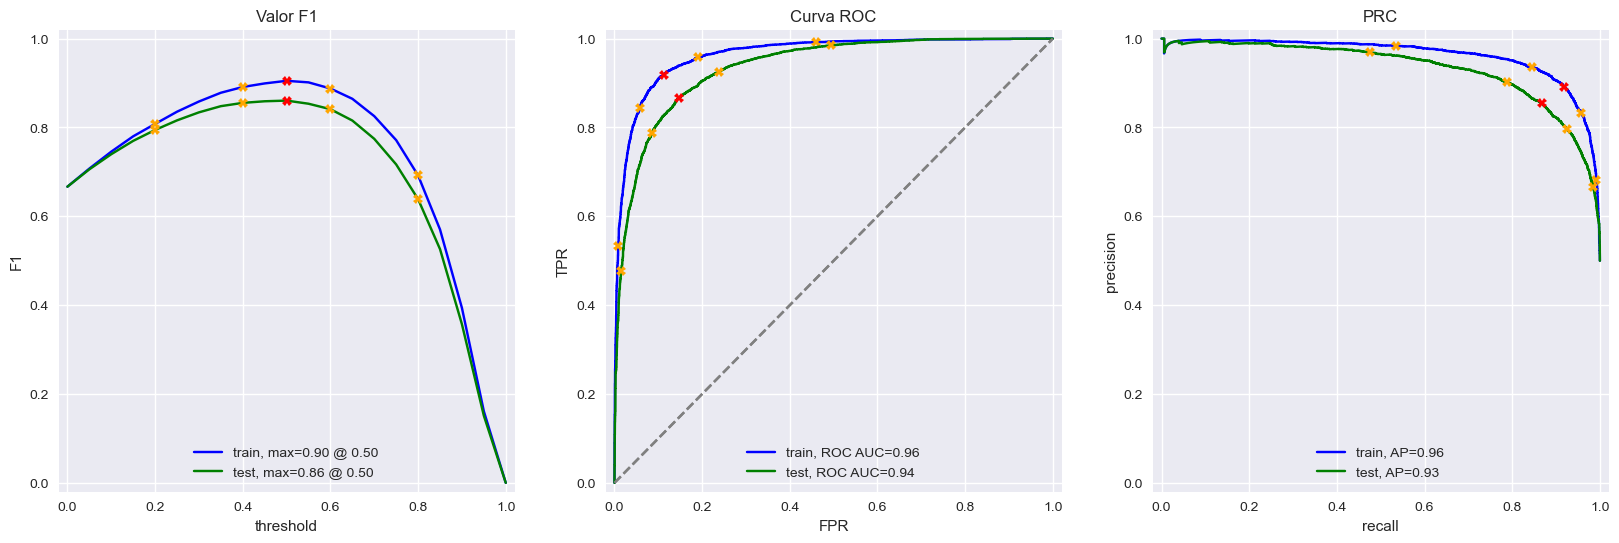

In [32]:
evaluate_model(spacy_lr, X_train, sample_train_target, X_test, sample_test_target)

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [33]:
from lightgbm import LGBMClassifier

In [34]:
lgbm_model = LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=12345, class_weight='balanced', n_jobs=-1)

lgbm_model.fit(X_train, sample_train_target)

[LightGBM] [Info] Number of positive: 5000, number of negative: 5000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159690
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=5,
               n_estimators=200, n_jobs=-1, random_state=12345)

c:\Users\lalox\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lalox\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lalox\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lalox\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


           train  test
Exactitud    NaN   NaN
F1          0.88  0.82
APS         0.95  0.90
ROC AUC     0.96  0.90


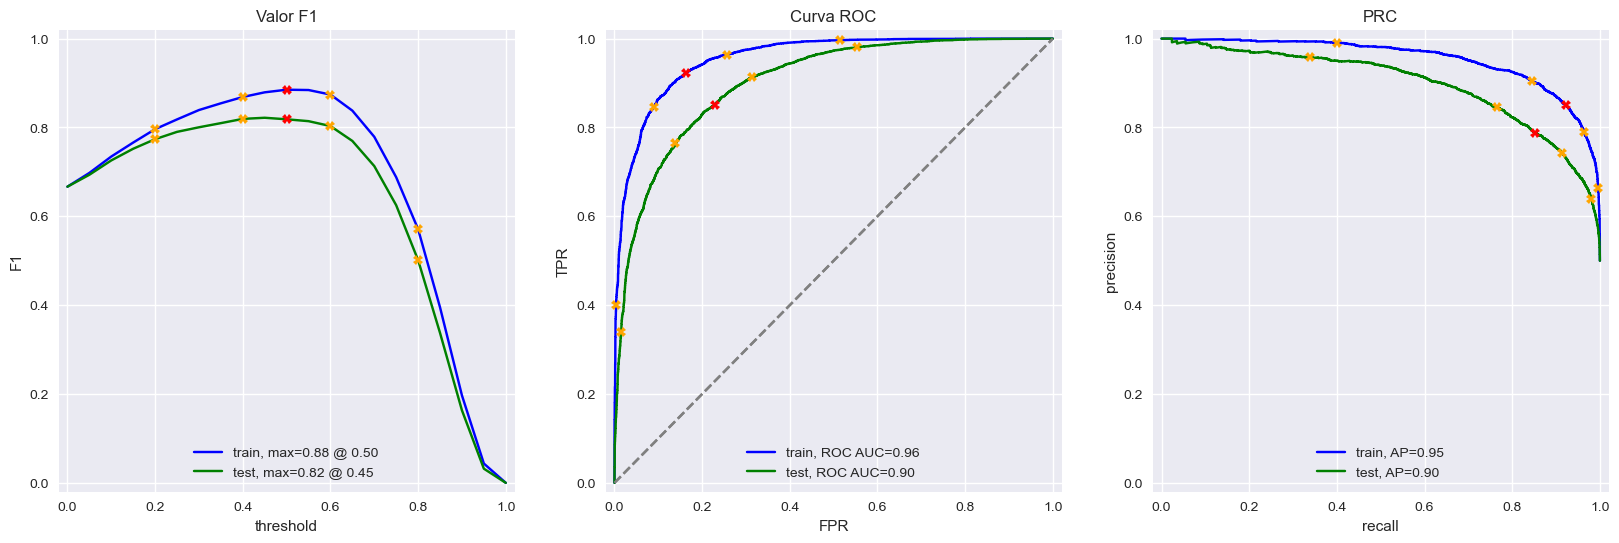

In [35]:
evaluate_model(lgbm_model, X_train, sample_train_target, X_test, sample_test_target)

## Mis reseñas

In [51]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos
reviews = pd.DataFrame({
    'review': [
        "The movie was a complete disaster, with terrible acting and a nonsensical plot.",
        "I'd rather watch paint dry than sit through this again. Absolute waste of money.",
        "Not even the impressive visuals could save this boring, cliché-ridden mess.",
        "A breathtaking cinematic experience! The story kept me engaged until the last minute.",
        "The director's vision shines through every frame - a modern masterpiece.",
        "Perfect casting and brilliant dialogue. One of the best films this year!",
        "It had its moments, but overall felt forgettable. Not bad, not great.",
        "The first half was fantastic, but it lost steam in the final act.",
        "Solid performances, though the script needed more polish.",
        "Oh sure, because what we needed was another soulless reboot. Just brilliant."
    ],
    'true_sentiment': [0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
})

reviews['clear_text'] = [clear_text(text) for text in reviews['review']]

X_reviews = vectorizer.transform(reviews['clear_text'])

### Modelo 1

In [ ]:
# Normalizamos el texto de las reseñas
reviews['review_norm'] = reviews['review'].apply(normalize_text)
reviews_tfidf = tfidf_vectorizer.transform(reviews['review_norm'])

reviews['predicted_sentiment'] = logistic_model.predict(reviews_tfidf)

# Predecimos las probabilidades de cada clase
probabilities = logistic_model.predict_proba(reviews_tfidf)
reviews['prob_negative'] = probabilities[:, 0]
reviews['prob_positive'] = probabilities[:, 1]

# Resultado final con comparación
reviews['prediction_correct'] = reviews['true_sentiment'] == reviews['predicted_sentiment']

print(reviews[['review', 'true_sentiment', 'predicted_sentiment', 'prediction_correct', 'prob_positive']])

                                              review  true_sentiment  \
0  The movie was a complete disaster, with terrib...               0   
1  I'd rather watch paint dry than sit through th...               0   
2  Not even the impressive visuals could save thi...               0   
3  A breathtaking cinematic experience! The story...               1   
4  The director's vision shines through every fra...               1   
5  Perfect casting and brilliant dialogue. One of...               1   
6  It had its moments, but overall felt forgettab...               0   
7  The first half was fantastic, but it lost stea...               1   
8  Solid performances, though the script needed m...               0   
9  Oh sure, because what we needed was another so...               0   

   predicted_sentiment  prediction_correct  prob_positive  
0                    0                True       0.018986  
1                    0                True       0.022815  
2                    0     

### Modelo 2

In [54]:
# Predecimos la polaridad de las reseñas utilizando el modelo entrenado

reviews['predicted_sentiment'] = spacy_lr.predict(X_reviews)


probabilities = spacy_lr.predict_proba(X_reviews)
reviews['prob_negative'] = probabilities[:, 0]
reviews['prob_positive'] = probabilities[:, 1]

# Resultado final con comparación
reviews['prediction_correct'] = reviews['true_sentiment'] == reviews['predicted_sentiment']

print(reviews[['review', 'true_sentiment', 'predicted_sentiment', 'prediction_correct', 'prob_positive']])

                                              review  true_sentiment  \
0  The movie was a complete disaster, with terrib...               0   
1  I'd rather watch paint dry than sit through th...               0   
2  Not even the impressive visuals could save thi...               0   
3  A breathtaking cinematic experience! The story...               1   
4  The director's vision shines through every fra...               1   
5  Perfect casting and brilliant dialogue. One of...               1   
6  It had its moments, but overall felt forgettab...               0   
7  The first half was fantastic, but it lost stea...               1   
8  Solid performances, though the script needed m...               0   
9  Oh sure, because what we needed was another so...               0   

   predicted_sentiment  prediction_correct  prob_positive  
0                    0                True       0.030650  
1                    0                True       0.030299  
2                    0     

### Modelo 3

In [65]:
# Predecimos la polaridad de las reseñas utilizando el modelo LGBM

reviews['predicted_sentiment'] = lgbm_model.predict(X_reviews)


probabilities = lgbm_model.predict_proba(X_reviews)
reviews['prob_negative'] = probabilities[:, 0]
reviews['prob_positive'] = probabilities[:, 1]

# Resultado final con comparación
reviews['prediction_correct'] = reviews['true_sentiment'] == reviews['predicted_sentiment']

print(reviews[['review', 'true_sentiment', 'predicted_sentiment', 'prediction_correct', 'prob_positive']])

                                              review  true_sentiment  \
0  The movie was a complete disaster, with terrib...               0   
1  I'd rather watch paint dry than sit through th...               0   
2  Not even the impressive visuals could save thi...               0   
3  A breathtaking cinematic experience! The story...               1   
4  The director's vision shines through every fra...               1   
5  Perfect casting and brilliant dialogue. One of...               1   
6  It had its moments, but overall felt forgettab...               0   
7  The first half was fantastic, but it lost stea...               1   
8  Solid performances, though the script needed m...               0   
9  Oh sure, because what we needed was another so...               0   

   predicted_sentiment  prediction_correct  prob_positive  
0                    0                True       0.283682  
1                    0                True       0.089293  
2                    0     

c:\Users\lalox\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lalox\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Conclusiones

El modelo que obtuvo el mejor rendimiento fue Logistic Regression entrenado con texto normalizado mediante TF-IDF, alcanzando un F1-score de 0.88 en el conjunto de prueba. Además, en pruebas con nuevas reseñas, solo se equivocó en una ocasión, demostrando su capacidad de generalización.

En contraste, el mismo modelo de Logistic Regression, pero entrenado con texto normalizado usando spaCy, obtuvo un F1-score de 0.86 y cometió tres errores en las pruebas adicionales.

Por otro lado, el modelo LGBM, también entrenado con texto normalizado con spaCy, logró un F1-score de 0.82, con dos errores en las pruebas adicionales.

Estos resultados indican que la combinación de Logistic Regression con TF-IDF fue la más efectiva para este análisis de sentimiento, superando tanto a la versión basada en spaCy como al modelo LGBM.

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 